In [2]:
import numpy as np
import cv2 # OpenCV-Python
import pandas as pd
from pandas import Series
%matplotlib inline
import matplotlib.pyplot as plt


# 単純な閾値処理

閾値処理の方法は単純: 画素値が閾値より大きければある値(白色)を割り当て，そうでなければ別の値(黒色)を割り当てる。使われる関数は cv2.threshold(img, thresh, maxVal, type) で、第1引数imgは入力画像で グレースケール画像でなければならない ．第2引数threshは閾値で，画素を分類するのに使われ、第3引数maxValは閾値以上(指定により閾値以下のこともある)の値を持つ画素に対して割り当てられる値である．OpenCVは何通りかの閾値処理を用意しており，第4引数typeにて指定する．以下がtypeの値の一覧である:

cv2.THRESH_BINARY

cv2.THRESH_BINARY_INV

cv2.THRESH_TRUNC

cv2.THRESH_TOZERO

cv2.THRESH_TOZERO_INV

cv2.threshold は出力を２つ返す．出力の一つ retval については後述する．二つ目の出力が、閾値処理された後の 二値画像 である．


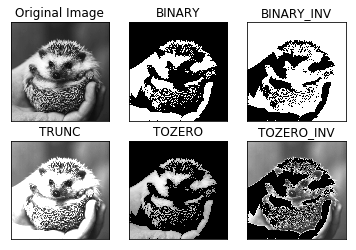

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('../../img/hari.jpg',0)
ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

# 適応的閾値処理

先の例では、ある画像に対して一つの閾値を与えて閾値処理をした。しかし、撮影条件により画像領域で異なる光源環境となるような画像に対しては期待する結果が得られない．そういう状況では「適応的閾値処理」を使うと良い．適応的閾値処理では，画像の小領域ごとに閾値の値を計算する．そのため領域によって光源環境が変わるような画像に対しては，単純な閾値処理より良い結果が得られる．

適応的閾値処理には cv2.adaptiveThreshold(AdaptiveMethod, BlockSize,C) 関数を使用し，次に示す3つの 「特殊な」入力パラメータを指定する．ただしcv2.threshold とは異なり，出力は一つ(二値画像)しかない．

Adaptive Method(適応的処理) - 小領域中での閾値の計算方法

cv2.ADAPTIVE_THRESH_MEAN_C : 近傍領域の中央値を閾値とする．

cv2.ADAPTIVE_THRESH_GAUSSIAN_C : 近傍領域の重み付け平均値を閾値とする．重みの値はGaussian分布になるように計算．

Block Size(領域サイズ): 閾値計算に使用する近傍領域のサイズ。ただし1より大きい奇数でなければならない．

C (定数): 計算された閾値から引く定数．

次は，領域ごとに光源環境が大きく異なる画像に対して，単純な閾値処理と適応的閾値処理でどのように異なる結果が得られるかを示すコードの例



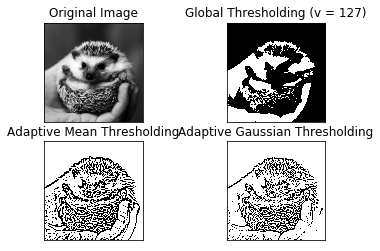

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('../../img/hari.jpg',0)
img = cv2.medianBlur(img,5)

ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()


# 大津の二値化

前にあげた cv2.threshold 関数の二つ目の出力 retVal は大津の二値化に使われる．

大局的閾値処理では閾値の値は任意に定めることができる．では，どのような値を選べば良いのだろうか？何回か試行錯誤すればよいが，ここでは入力画像が bimodal image (ヒストグラムが双峰性を持つような画像)であることを仮定すると、そのような画像に対して，二つのピークの間の値を閾値として選べば良いと考えることであろう。これが大津の二値化の手法である．簡単に言うと，画像のヒストグラムを基に閾値を決定する方法と言える．そのため，双峰性を持たないヒストグラムを持つ画像に対しては良い結果が得られないことになる．

関数は大局的閾値処理と同じ cv2.threshold を使うが，引数に cv2.THRESH_OTSU を追加する必要がある. また閾値には0を指定する．これにより自動的に閾値を計算してくれ，二つ目の出力値である retVal として返してくれる．大津の二値化を使わない場合は， retVal の値は入力引数に指定した閾値と同じ値になる．

以下の例を見てみよう．ノイズが含まれる入力画像に対して３通りの方法を試している．一つ目の方法は閾値を127に設定した単純な閾値処理であり、二つ目の方法は大津の二値化を適用している．三つ目の方法は，5x5のサイズのGaussianフィルタでノイズを抑制した画像に対し大津の二値化を適用する． 平滑化処理によってノイズの影響が軽減されていることが分かる 


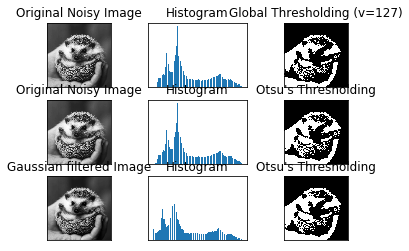

In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('../../img/hari.jpg',0)

# global thresholding
ret1,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()
